<a href="https://colab.research.google.com/gist/lgariv/5daf13ced057fb0b77d58a18fb1b4cdb/train_mask_classifier_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/lgariv/mask-dataset.git

Cloning into 'mask-dataset'...
remote: Enumerating objects: 5524, done.
remote: Total 5524 (delta 0), reused 0 (delta 0), pack-reused 5524
Receiving objects: 100% (5524/5524), 518.36 MiB | 50.81 MiB/s, done.
Resolving deltas: 100% (868/868), done.
Checking out files: 100% (7251/7251), done.


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 17.5MB/s 


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
# import argparse
import os

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
pathname = "/content/mask-dataset/dataset"
print("[INFO] loading images...")
imagePaths = list(paths.list_images(pathname))
data = []
labels = []

[INFO] loading images...


In [ ]:
#@title Sort images and labels

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
#@title Split and construct the training image generator for data augmentation

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [ ]:
#@title Load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# model.summary()

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
model = tf.keras.Sequential([
    tf.keras.layers.Input((224, 224, 3)),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4", 
                   trainable=True),
    # tf.keras.layers.AveragePooling2D(pool_size=(7,7)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
#@title Loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = True

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
#@title Train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 50s 404ms/step - loss: 0.4799 - accuracy: 0.8323 - val_loss: 0.1105 - val_accuracy: 0.9909
Epoch 2/20
95/95 [==============================] - 38s 394ms/step - loss: 0.1167 - accuracy: 0.9898 - val_loss: 0.0962 - val_accuracy: 0.9961
Epoch 3/20
95/95 [==============================] - 38s 397ms/step - loss: 0.0961 - accuracy: 0.9971 - val_loss: 0.0924 - val_accuracy: 0.9974
Epoch 4/20
95/95 [==============================] - 38s 398ms/step - loss: 0.0928 - accuracy: 0.9978 - val_loss: 0.0996 - val_accuracy: 0.9948
Epoch 5/20
95/95 [==============================] - 38s 397ms/step - loss: 0.1005 - accuracy: 0.9942 - val_loss: 0.0901 - val_accuracy: 0.9974
Epoch 6/20
95/95 [==============================] - 38s 396ms/step - loss: 0.0913 - accuracy: 0.9976 - val_loss: 0.0869 - val_accuracy: 0.9974
Epoch 7/20
95/95 [==============================] - 38s 395ms/step - loss: 0.0874 - accuracy: 0.9989 - val_loss: 0.085

In [ ]:
#@title Make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("/content/mask_detector.h5", save_format="h5")

import tensorflow as tf
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(trainX).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.representative_dataset = representative_data_gen

tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       383
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

[INFO] saving mask detector model...
INFO:tensorflow:Assets written to: /tmp/tmp_d89qa3v/assets


INFO:tensorflow:Assets written to: /tmp/tmp_d89qa3v/assets


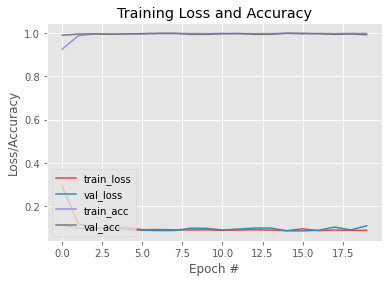

In [ ]:
#@title Plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/content/plot")

/content/mask-dataset/images/test/maksssksksss693.png


156 46 22 26
<class 'numpy.ndarray'> (1, 224, 224, 3)


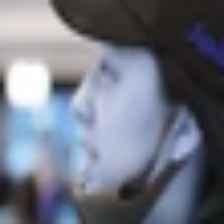

box: [156, 46, 22, 26], class: [[0.9773483  0.02265167]]


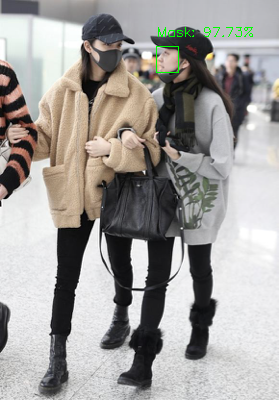

/content/mask-dataset/images/test/maksssksksss825.png
226 27 27 30
<class 'numpy.ndarray'> (1, 224, 224, 3)


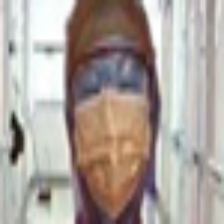

49 27 34 36
<class 'numpy.ndarray'> (1, 224, 224, 3)


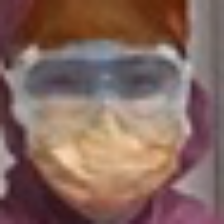

box: [226, 27, 27, 30], class: [[0.73146975 0.26853025]]
box: [49, 27, 34, 36], class: [[0.9494558  0.05054418]]


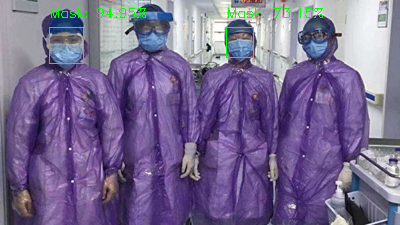

In [ ]:
#@title Feeding mtcnn FaceNet cropping into mask detector visualization
check = True #@param {type:"boolean"}

if check:
    from google.colab.patches import cv2_imshow
    from keras.models import load_model
    from PIL import Image
    import keras
    import numpy as np
    import random
    import glob

    from mtcnn import MTCNN
    import cv2

    detector = MTCNN()

    with_mask_val = '/content/mask-dataset/images/test'
    without_mask_val = '/content/mask-dataset/images/test'

    val_set = [with_mask_val, without_mask_val]

    for fn in val_set:
        face_boxes = []
        crops = []
        classes = []

        # predicting images
        for ext in ('*/*.png', '*/*.jpg', '*/*.jpeg', '*/*.PNG', '*/*.JPG', '*/*.JPEG'):
            try:
                path = f"{random.choice(glob.glob(fn+ext))}"
                print(path)
                break
            except:
                print('nope')
                continue

        img = img_orig = cv2.imread(path)
        img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
        for result in detector.detect_faces(img):
            if float(result['confidence']) > float(0.50):
                # img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
                face_box = result['box']
                (startX, startY, width, height) = face_box
                print(f'{startX} {startY} {width} {height}')
                face_boxes.append(face_box)

                # Setting the points for cropped image
                left = float(startX)
                top = float(startY)
                right = float(width+startX)
                bottom = float(height+startY)
                # print(f'{left} {top} {right} {bottom}')

                left = left - (left*0.1)
                top = top - (top*0.1)
                right = right + (right*0.1)
                bottom = bottom + (bottom*0.1)
                # print(f'{left} {top} {right} {bottom}')

                # new_width = right-left
                # new_height = bottom-top

                # new_face_box = (int(left), int(top), int(new_width), int(new_height))
                # face_boxes.append(new_face_box)

                # Cropped image of above dimension
                # (It will not change orginal image)
                # im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2BGR)
                im1 = img[int(top):int(bottom), int(left):int(right)]
                im1 = cv2.resize(im1, (224, 224))
                crop = keras.preprocessing.image.img_to_array(im1)
                crop = np.expand_dims(crop, axis=0)
                crops.append(crop)
                print(type(crop), crop.shape)
                cv2_imshow(im1)

                # try:
                classes.append(model.predict(crop))
                # except:
                #     classes.append(my_model.predict(crop))

        for (box, class_label) in zip(face_boxes, classes):
            print(f'box: {box}, class: {class_label}')

            # unpack the bounding box and predictions
            (startX, startY, width, height) = box
            (mask, withoutMask) = class_label[0]

            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (255, 0, 0)

            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            # display the label and bounding box rectangle on the output
            # frame
            cv2.putText(img_orig, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 1)
            cv2.rectangle(img_orig, (startX, startY), (width+startX, height+startY), color, 1)

        # All the results have been drawn on the frame, so it's time to display it.
        cv2_imshow(img_orig)

In [ ]:
#@title Download
download_tflite = False #@param {type:"boolean"}
download_keras = False #@param {type:"boolean"}
from google.colab import files

if download_tflite:
    files.download('model.tflite')
if download_keras:
    files.download('mask_detector.h5')